<a href="https://colab.research.google.com/github/asif-khan98/Thesis/blob/main/Bitter_Gourd_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dependencies

In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator



## Data Augmentation

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

# for i in os.listdir("data/Downey mildew"):

#     path = os.path.join("data/Downey mildew",i)
#     img = load_img(path)  # this is a PIL image
#     print(path)
#     x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
#     x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

#     # the .flow() command below generates batches of randomly transformed images
#     # and saves the results to the `preview/` directory
#     i = 0
#     for batch in datagen.flow(x, batch_size=1,
#                               save_to_dir='data1/Downey mildew', save_prefix='pic', save_format='jpeg'):
#         i += 1
#         if i > 2:
#             break  # otherwise the generator would loop indefinitely

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=25
n_classes = 3

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data1",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2136 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Downey mildew', 'Healthy leaf', 'Powdery mildew']

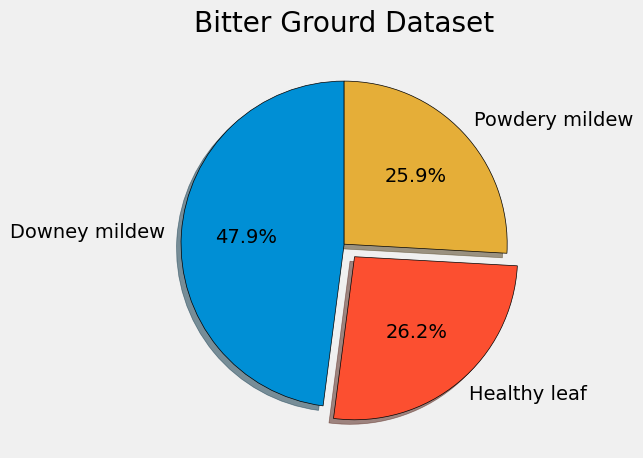

In [ ]:
#More customizations
#Real world data
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Language Popularity
#python is not good with a lot of data so we shall modify our list to top 5 languages.
slices = [1024,559,553]
labels = ['Downey mildew', 'Healthy leaf', 'Powdery mildew']
explode = [0, 0.1, 0] #this puts an emphasis on python

plt.pie(slices, labels = labels, explode = explode,
        #shadow = True for asthetics to add a shadow to our plot
        shadow = True,
        #startangle = 90, rotates the original chart by 90 degress
        startangle = 90,
        #autopct = '%1.1f%%' for adding the % value for each element. Refer to documentation to confirm
        autopct = '%1.1f%%',
        wedgeprops = {'edgecolor': 'black'})

#wedgeprops is to put a boundary where the two colors meet.
#more on the matplotlib wedge documentation for more customisations.

plt.title('Bitter Grourd Dataset')
plt.tight_layout()
plt.show()

## Importing Dataset

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 2 2 2 0 2 2 2 2 0 1 0 2 0 1 0 0 0 0 0 1 0 0 2 0 2 1 2 1]


## Visualizing Dataset

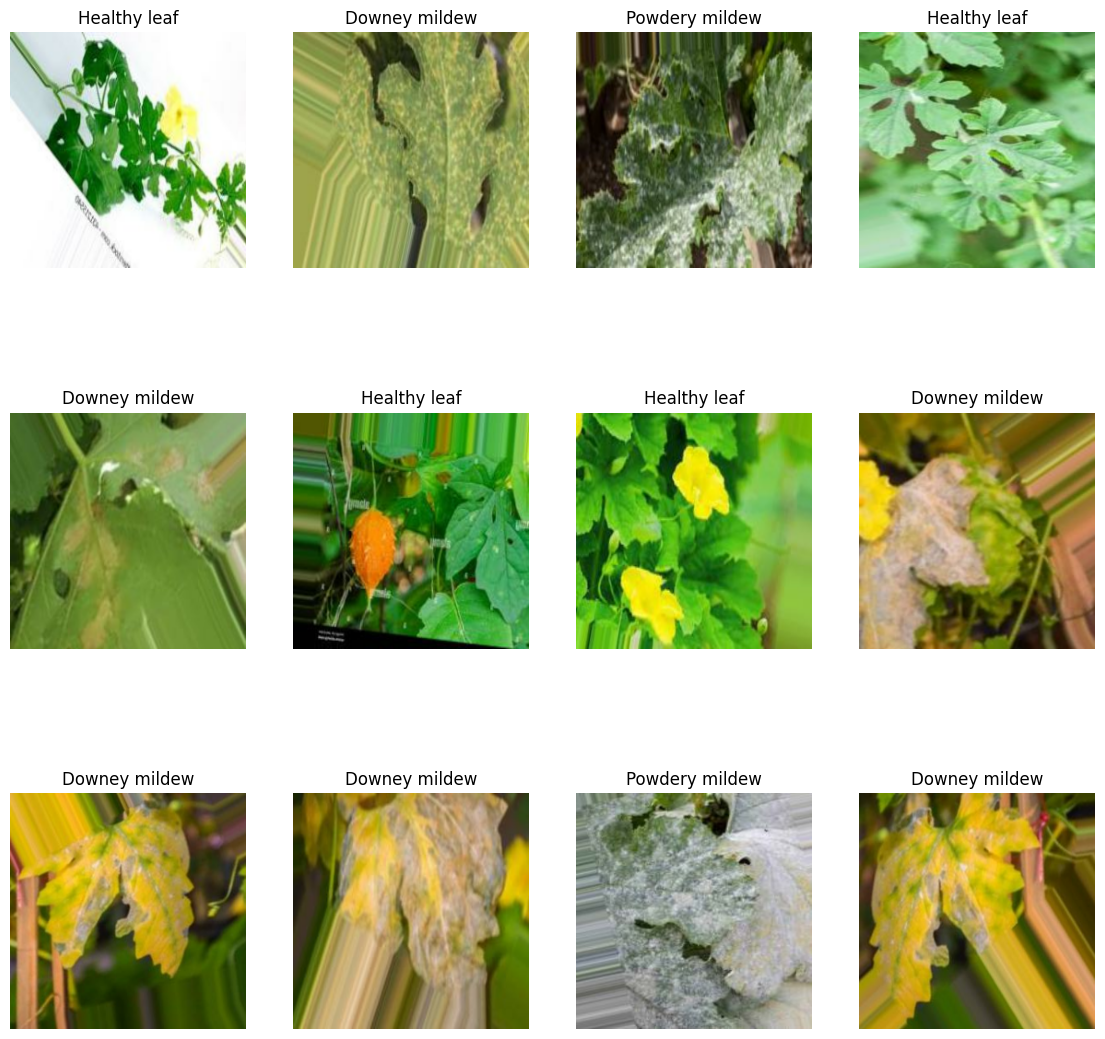

In [ ]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Train Test Split

In [ ]:
train_size = 0.7
len(dataset)*train_size

46.9

In [ ]:
train_ds = dataset.take(26)
len(train_ds)

26

In [ ]:
test_ds = dataset.skip(26)
len(test_ds)

41

In [ ]:
val_size=0.15
len(dataset)*val_size

10.049999999999999

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

35

In [ ]:
#train data 70%, Test data 15%, Validation 15%
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

46

In [ ]:
len(val_ds)

10

In [ ]:
len(test_ds)

11

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## General Preprocess and Augmentation

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building The Model

Staring from Basic few layer CNN Architecture to Multiple layers CNN Model with Batch Normalization And then will compare the proposed best CNN with PreBuild CNN Models (Transfer Learning Models)

## CNN Model Architecture: 01

CNN with 4 layers of convulation+Pooling layers and dense with unit size of 512. The CNN is a stacking of alternating Conv2D with Relu as an activation function and MaxPooling2D layers. Input of size 256 x 256, and immediately before the Flatten layer, will end up with feature maps of size 14 x 14.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model_01 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_01.build(input_shape=input_shape)

In [ ]:
model_01.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [ ]:
model_01.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history_01 = model_01.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
46/46 [==============================] - 59s 1s/step - loss: 1.0512 - accuracy: 0.5642 - val_loss: 0.5696 - val_accuracy: 0.8301
Epoch 2/25
46/46 [==============================] - 56s 1s/step - loss: 0.4995 - accuracy: 0.8067 - val_loss: 0.3862 - val_accuracy: 0.8429
Epoch 3/25
46/46 [==============================] - 59s 1s/step - loss: 0.3704 - accuracy: 0.8531 - val_loss: 0.2941 - val_accuracy: 0.8750
Epoch 4/25
46/46 [==============================] - 58s 1s/step - loss: 0.3086 - accuracy: 0.8743 - val_loss: 0.3122 - val_accuracy: 0.8718
Epoch 5/25
46/46 [==============================] - 58s 1s/step - loss: 0.3163 - accuracy: 0.8770 - val_loss: 0.2605 - val_accuracy: 0.8814
Epoch 6/25
46/46 [==============================] - 58s 1s/step - loss: 0.2804 - accuracy: 0.8928 - val_loss: 0.2045 - val_accuracy: 0.9103
Epoch 7/25
46/46 [==============================] - 57s 1s/step - loss: 0.2498 - accuracy: 0.9023 - val_loss: 0.3354 - val_accuracy: 0.8622
Epoch 8/25
46/46 [==

In [ ]:
scores_01 = model_01.evaluate(test_ds)

11/11 [==============================] - 4s 262ms/step - loss: 0.0545 - accuracy: 0.9744


## Plotting the Accuracy of Model 01

In [ ]:
acc_01 = history_01.history['accuracy']
val_acc_01 = history_01.history['val_accuracy']

loss_01 = history_01.history['loss']
val_loss_01 = history_01.history['val_loss']

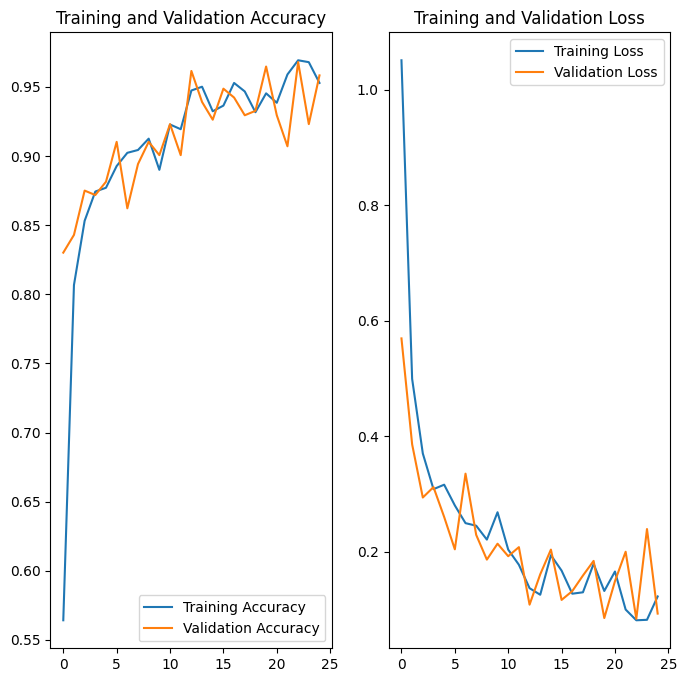

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_01, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_01, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_01, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_01, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cnn_acc_01=scores_01[1]*100
print(f"Test Accuracy: ",cnn_acc_01)

Test Accuracy:  97.44318127632141


## CNN Model Architecture: 02

CNN with 4 layers of convulation+Pooling layers and dense 512 with Batch normalization and Dropout Layer. The CNN is a stacking of alternating Conv2D with Relu as an activation function and MaxPooling2D layers. I have also used the BatchNormalization layer in order to improve the performance of the model in terms of its training as well as validation accuracies.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model_02 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),

    layers.Dense(n_classes, activation='softmax'),
])

model_02.build(input_shape=input_shape)

In [ ]:
model_02.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (32, 127, 127, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 62, 62, 64)        

In [ ]:
model_02.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history_02 = model_02.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
46/46 [==============================] - 70s 1s/step - loss: 0.5378 - accuracy: 0.8436 - val_loss: 2.1094 - val_accuracy: 0.4615
Epoch 2/25
46/46 [==============================] - 68s 1s/step - loss: 0.3015 - accuracy: 0.8887 - val_loss: 2.9625 - val_accuracy: 0.4615
Epoch 3/25
46/46 [==============================] - 67s 1s/step - loss: 0.2126 - accuracy: 0.9119 - val_loss: 2.7921 - val_accuracy: 0.4615
Epoch 4/25
46/46 [==============================] - 68s 1s/step - loss: 0.1767 - accuracy: 0.9269 - val_loss: 3.5373 - val_accuracy: 0.4615
Epoch 5/25
46/46 [==============================] - 68s 1s/step - loss: 0.1556 - accuracy: 0.9385 - val_loss: 3.0333 - val_accuracy: 0.4615
Epoch 6/25
46/46 [==============================] - 69s 1s/step - loss: 0.1450 - accuracy: 0.9413 - val_loss: 1.3794 - val_accuracy: 0.5673
Epoch 7/25
46/46 [==============================] - 69s 1s/step - loss: 0.1602 - accuracy: 0.9460 - val_loss: 2.6728 - val_accuracy: 0.5481
Epoch 8/25
46/46 [==

In [ ]:
scores_02 = model_02.evaluate(test_ds)

11/11 [==============================] - 3s 266ms/step - loss: 0.0619 - accuracy: 0.9830


## Plotting the Accuracy of Model 02

In [ ]:
acc_02 = history_02.history['accuracy']
val_acc_02= history_02.history['val_accuracy']

loss_02 = history_02.history['loss']
val_loss_02 = history_02.history['val_loss']


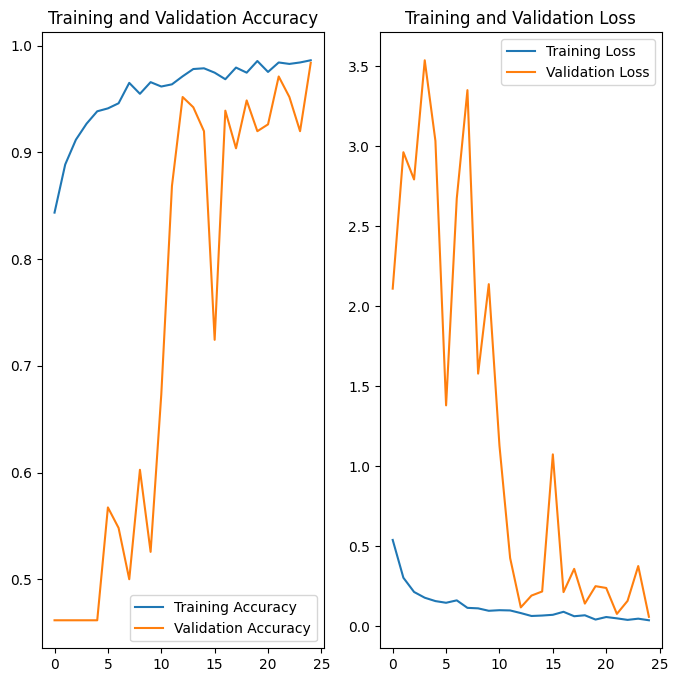

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_02, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_02, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_02, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_02, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cnn_acc_02=scores_02[1]*100
print(f"Test Accuracy: ",cnn_acc_02)

Test Accuracy:  98.29545617103577


## InceptionV3 Model: 05

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)

output  = Dense(units=n_classes, activation='softmax')(x)
model_05 = Model(InceptionV3_model.input, output)


In [ ]:
model_05.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 127, 127, 32  96         ['conv2d_16[0][0]']              
 rmalization)                   )                                                           

 conv2d_27 (Conv2D)             (None, 29, 29, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 64)  192         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_13 (BatchN  (None, 29, 29, 64)  192         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_16 (BatchN  (None, 29, 29, 96)  288         ['conv2d_26[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_38 (Conv2D)             (None, 29, 29, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 29, 29, 64)  192         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_28[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_39

                                                                                                  
 activation_29 (Activation)     (None, 14, 14, 96)   0           ['batch_normalization_35[0][0]'] 
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_50

 mixed4 (Concatenate)           (None, 14, 14, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_60 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_50 (BatchN  (None, 14, 14, 160)  480        ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_70 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_60 (BatchN  (None, 14, 14, 160)  480        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_60[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 14, 14, 160)  480        ['conv2d_71[0][0]']              
 ormalizat

 activation_64 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 conv2d_81 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_71 (BatchN  (None, 14, 14, 192)  576        ['conv2d_81[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_71[0][0]'] 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_90 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 192)  576        ['conv2d_86[0][0]']              
 ormalization)                                                                                    
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_100 (Conv2D)            (None, 6, 6, 192)    245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_82 (BatchN  (None, 6, 6, 320)   960         ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_85[0][0]'] 
          

                                                                                                  
 activation_87 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_97[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_98[0][0]'] 
                                                                                                  
 batch_normalization_99 (BatchN  (None, 6, 6, 192)   576         ['conv2d_109[0][0]']             
 ormalizat

In [ ]:
model_05.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_05 = model_05.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
46/46 [==============================] - 48s 974ms/step - loss: 1.8758 - accuracy: 0.5335 - val_loss: 2.0564 - val_accuracy: 0.3590
Epoch 2/50
46/46 [==============================] - 45s 970ms/step - loss: 0.7946 - accuracy: 0.6714 - val_loss: 1.5704 - val_accuracy: 0.4455
Epoch 3/50
46/46 [==============================] - 45s 986ms/step - loss: 0.6716 - accuracy: 0.7411 - val_loss: 0.8934 - val_accuracy: 0.6154
Epoch 4/50
46/46 [==============================] - 46s 1000ms/step - loss: 0.5907 - accuracy: 0.7575 - val_loss: 0.8140 - val_accuracy: 0.6442
Epoch 5/50
46/46 [==============================] - 45s 972ms/step - loss: 0.5642 - accuracy: 0.7787 - val_loss: 0.5104 - val_accuracy: 0.8109
Epoch 6/50
46/46 [==============================] - 45s 982ms/step - loss: 0.5308 - accuracy: 0.7992 - val_loss: 0.8376 - val_accuracy: 0.6442
Epoch 7/50
46/46 [==============================] - 45s 972ms/step - loss: 0.5233 - accuracy: 0.7964 - val_loss: 0.7932 - val_accuracy: 0.628

In [ ]:
scores_05 = model_05.evaluate(test_ds)

11/11 [==============================] - 8s 745ms/step - loss: 0.1865 - accuracy: 0.9318


## Plotting the Accuracy of Model 05

In [ ]:
acc_05 = history_05.history['accuracy']
val_acc_05 = history_05.history['val_accuracy']

loss_05 = history_05.history['loss']
val_loss_05 = history_05.history['val_loss']

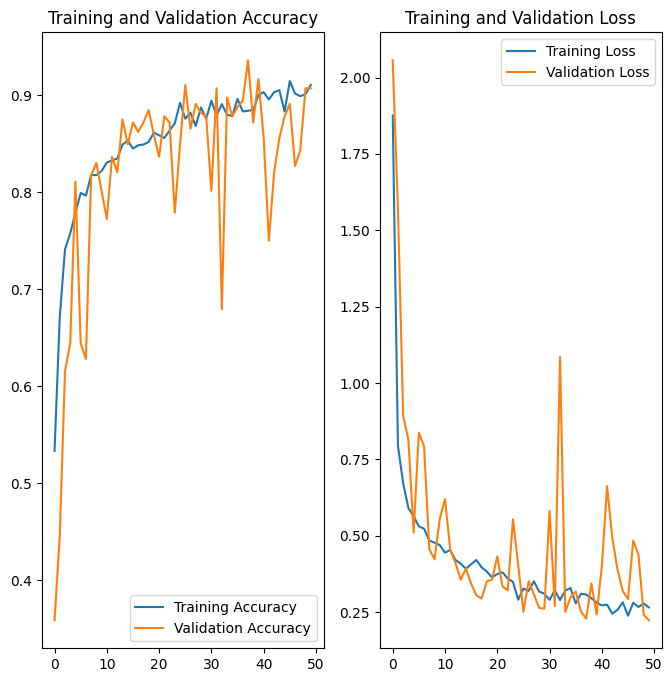

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc_05, label='Training Accuracy')
plt.plot(range(50), val_acc_05, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_05, label='Training Loss')
plt.plot(range(50), val_loss_05, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
inc_acc_05=scores_05[1]*100
print(f"Test Accuracy: ",inc_acc_05)

Test Accuracy:  93.18181872367859


## EfficientNetB4 Model: 06

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam

In [ ]:
efficientNetB4_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
efficientNetB4_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="input_layer")
x = data_augmentation(inputs)

x = efficientNetB4_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)



outputs = layers.Dense(n_classes, activation="softmax", name="output_layer")(x)
model_06 = tf.keras.Model(inputs, outputs)

In [ ]:
model_06.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_avg_pool_layer (Glob  (None, 1792)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 3)                 5379      
                                                                 
Total params: 17,679,202
Trainable params: 5,379
Non-trainable params: 17,673,823
___________________________________________

In [ ]:
model_06.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_06 = model_06.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=75,
)

Epoch 1/75
46/46 [==============================] - 134s 3s/step - loss: 1.2948 - accuracy: 0.2514 - val_loss: 1.2792 - val_accuracy: 0.1923
Epoch 2/75
46/46 [==============================] - 124s 3s/step - loss: 1.2456 - accuracy: 0.2555 - val_loss: 1.2433 - val_accuracy: 0.2083
Epoch 3/75
46/46 [==============================] - 127s 3s/step - loss: 1.2153 - accuracy: 0.2732 - val_loss: 1.2105 - val_accuracy: 0.2276
Epoch 4/75
46/46 [==============================] - 127s 3s/step - loss: 1.1839 - accuracy: 0.2801 - val_loss: 1.1789 - val_accuracy: 0.2628
Epoch 5/75
46/46 [==============================] - 128s 3s/step - loss: 1.1509 - accuracy: 0.3163 - val_loss: 1.1505 - val_accuracy: 0.2724
Epoch 6/75
46/46 [==============================] - 128s 3s/step - loss: 1.1191 - accuracy: 0.3422 - val_loss: 1.1241 - val_accuracy: 0.2692
Epoch 7/75
46/46 [==============================] - 126s 3s/step - loss: 1.0884 - accuracy: 0.3695 - val_loss: 1.0995 - val_accuracy: 0.2981
Epoch 8/75
46

Epoch 59/75
46/46 [==============================] - 125s 3s/step - loss: 0.5496 - accuracy: 0.8484 - val_loss: 0.5378 - val_accuracy: 0.8462
Epoch 60/75
46/46 [==============================] - 125s 3s/step - loss: 0.5445 - accuracy: 0.8429 - val_loss: 0.5326 - val_accuracy: 0.8462
Epoch 61/75
46/46 [==============================] - 125s 3s/step - loss: 0.5490 - accuracy: 0.8504 - val_loss: 0.5276 - val_accuracy: 0.8494
Epoch 62/75
46/46 [==============================] - 125s 3s/step - loss: 0.5372 - accuracy: 0.8525 - val_loss: 0.5226 - val_accuracy: 0.8494
Epoch 63/75
46/46 [==============================] - 125s 3s/step - loss: 0.5341 - accuracy: 0.8415 - val_loss: 0.5178 - val_accuracy: 0.8526
Epoch 64/75
46/46 [==============================] - 125s 3s/step - loss: 0.5295 - accuracy: 0.8572 - val_loss: 0.5131 - val_accuracy: 0.8526
Epoch 65/75
46/46 [==============================] - 125s 3s/step - loss: 0.5229 - accuracy: 0.8586 - val_loss: 0.5084 - val_accuracy: 0.8558
Epoch 

In [ ]:
scores_06 = model_06.evaluate(test_ds)

11/11 [==============================] - 24s 2s/step - loss: 0.4854 - accuracy: 0.8665


## Plotting the Accuracy of Model 06

In [ ]:
acc_06 = history_06.history['accuracy']
val_acc_06= history_06.history['val_accuracy']

loss_06 = history_06.history['loss']
val_loss_06 = history_06.history['val_loss']

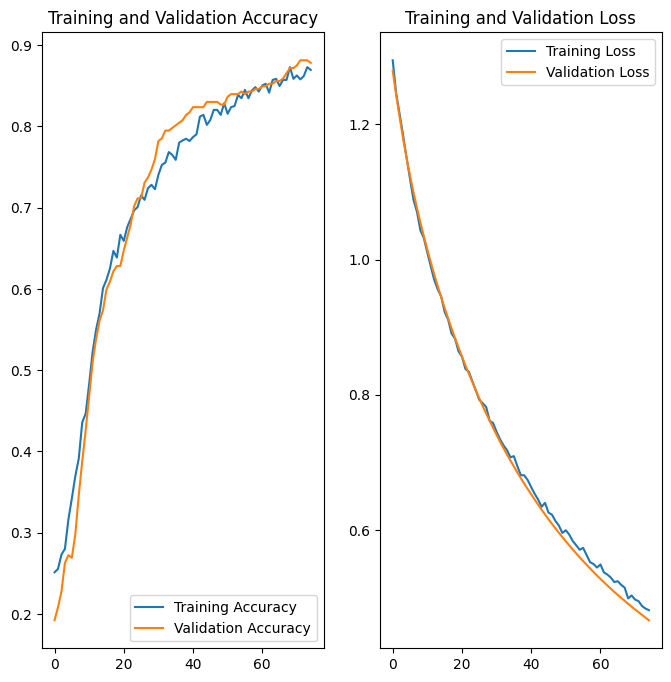

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(75), acc_06, label='Training Accuracy')
plt.plot(range(75), val_acc_06, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(75), loss_06, label='Training Loss')
plt.plot(range(75), val_loss_06, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
efn_acc_06=scores_06[1]*100
print(f"Test Accuracy: ",efn_acc_06)

Test Accuracy:  86.64772510528564


## Accuracy Comparison Plot Between Proposed And Transfer Learning Models

##  Run Prediction With CNN Architecture -02 on a sample image

first image to predict
actual label: Downey mildew
1/1 [==============================] - 1s 512ms/step
predicted label: Downey mildew


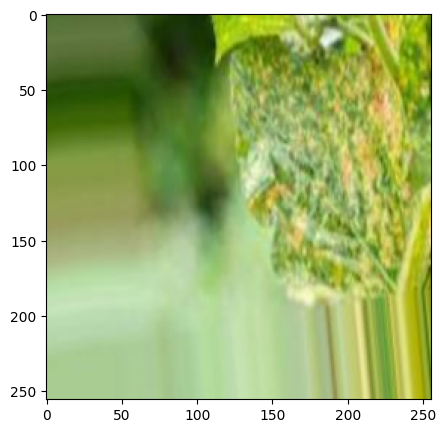

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_02.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_02.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


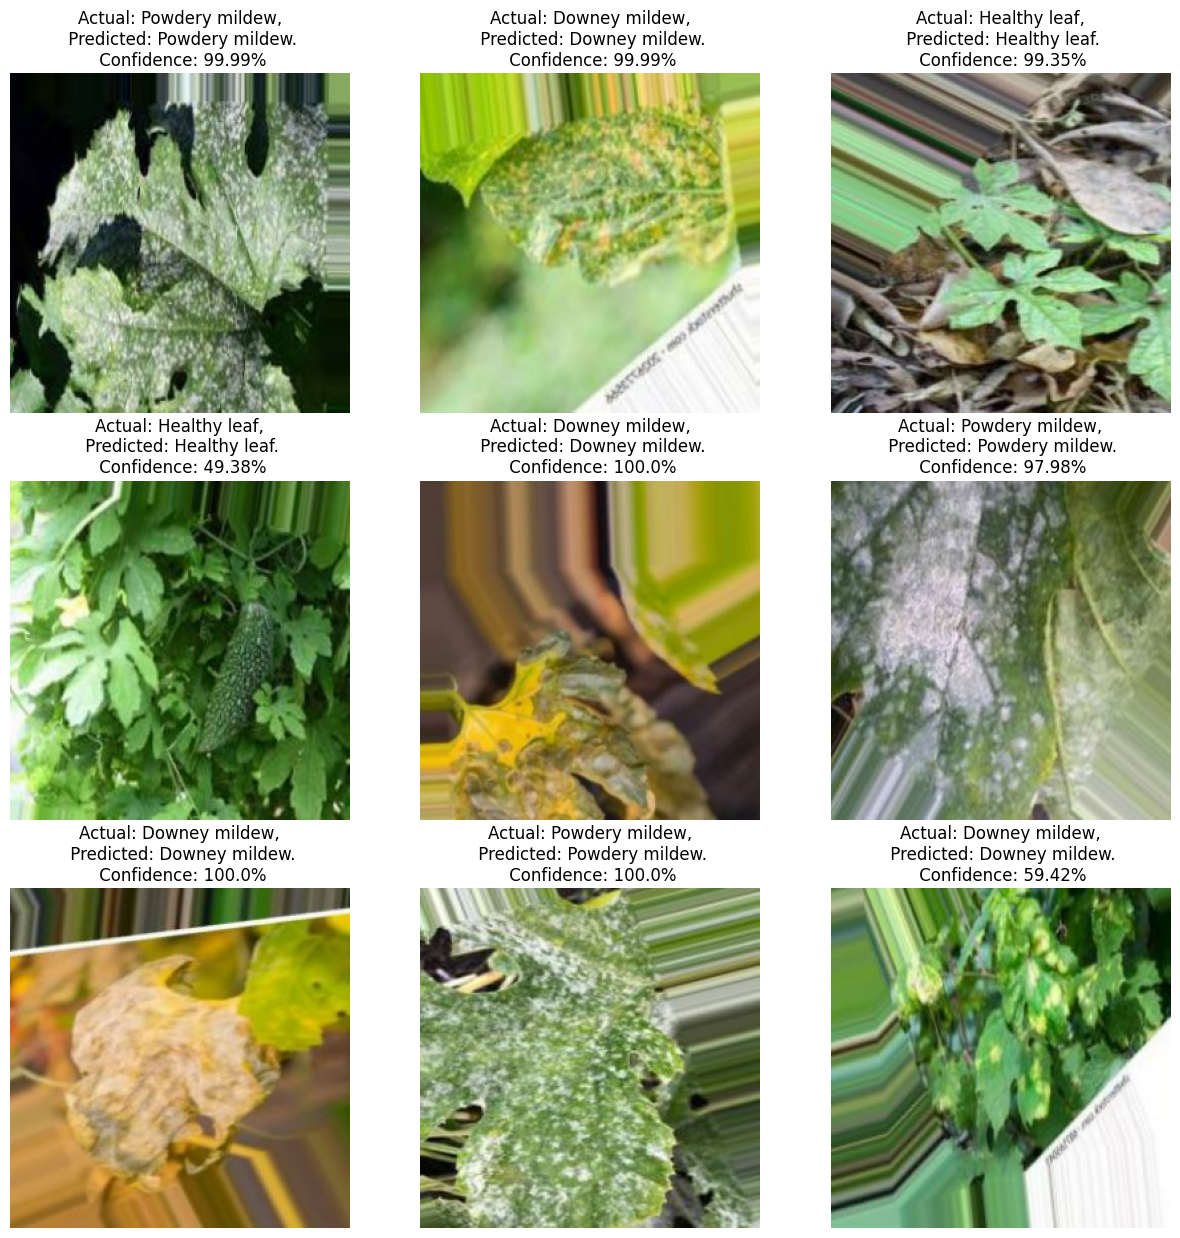

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_02, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


## Confusion Metrix


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def labels(model,dataset):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image_batch, label_batch in dataset:   # use dataset.unbatch() with repeat
       # append true labels
       y_true.append(label_batch)
       # compute predictions
       preds = model.predict(image_batch)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    return correct_labels , predicted_labels

## Confusion of model 02

1/1 [==============================] - 0s 301ms/step
Confusion matrix, without normalization
[[166   1   0]
 [  1  88   2]
 [  2   0  92]]


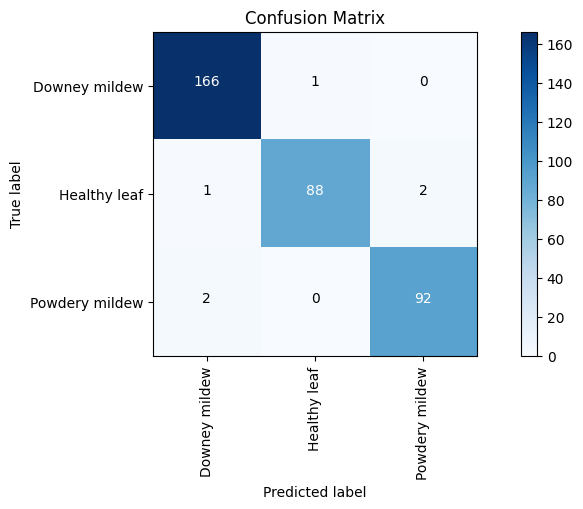

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels =  ['Downey mildew', 'Healthy leaf', 'Powdery mildew']
y_true,y_pred=labels(model_02,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       167
           1       0.99      0.97      0.98        91
           2       0.98      0.98      0.98        94

    accuracy                           0.98       352
   macro avg       0.98      0.98      0.98       352
weighted avg       0.98      0.98      0.98       352



## Confusion Matrix of model 01

1/1 [==============================] - 0s 277ms/step
Confusion matrix, without normalization
[[163   3   1]
 [  2  88   1]
 [  1   1  92]]


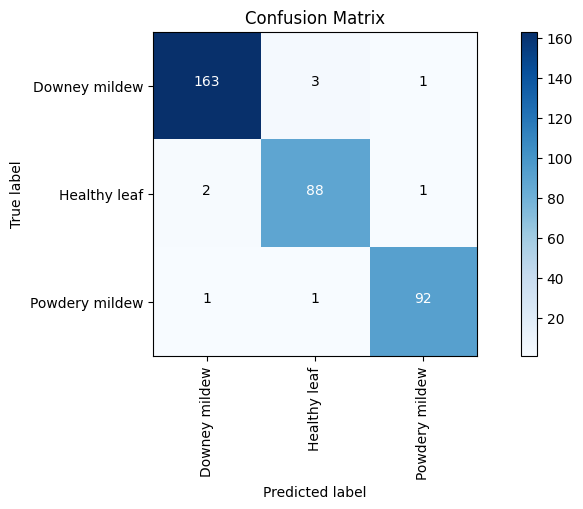

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels = ['Downey mildew', 'Healthy leaf', 'Powdery mildew']
y_true,y_pred=labels(model_01,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       167
           1       0.96      0.97      0.96        91
           2       0.98      0.98      0.98        94

    accuracy                           0.97       352
   macro avg       0.97      0.97      0.97       352
weighted avg       0.97      0.97      0.97       352



1/1 [==============================] - 1s 762ms/step
Confusion matrix, without normalization
[[157   8   2]
 [  0  88   3]
 [  5   6  83]]


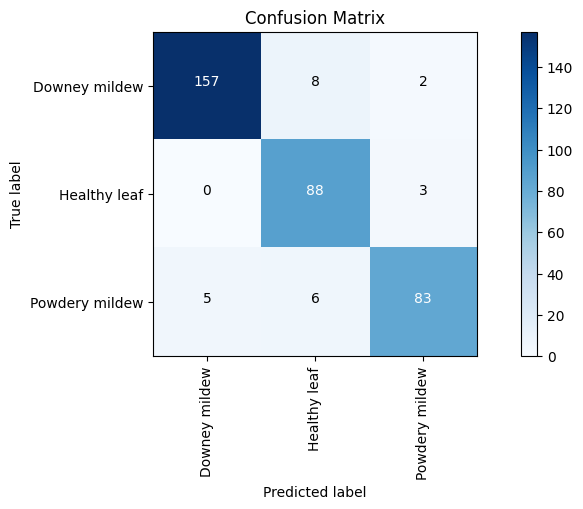

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels =  ['Downey mildew', 'Healthy leaf', 'Powdery mildew']
y_true,y_pred=labels(model_05,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       167
           1       0.86      0.97      0.91        91
           2       0.94      0.88      0.91        94

    accuracy                           0.93       352
   macro avg       0.93      0.93      0.93       352
weighted avg       0.93      0.93      0.93       352



1/1 [==============================] - 2s 2s/step
Confusion matrix, without normalization
[[155   4   8]
 [  8  77   6]
 [ 14   7  73]]


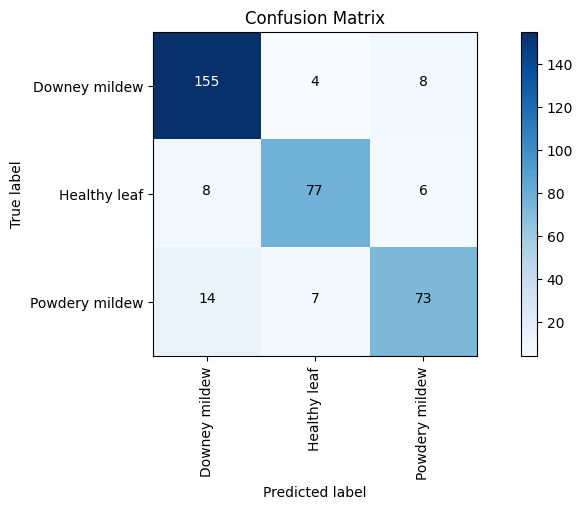

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels =  ['Downey mildew', 'Healthy leaf', 'Powdery mildew']
y_true,y_pred=labels(model_06,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       167
           1       0.88      0.85      0.86        91
           2       0.84      0.78      0.81        94

    accuracy                           0.87       352
   macro avg       0.86      0.85      0.86       352
weighted avg       0.87      0.87      0.87       352



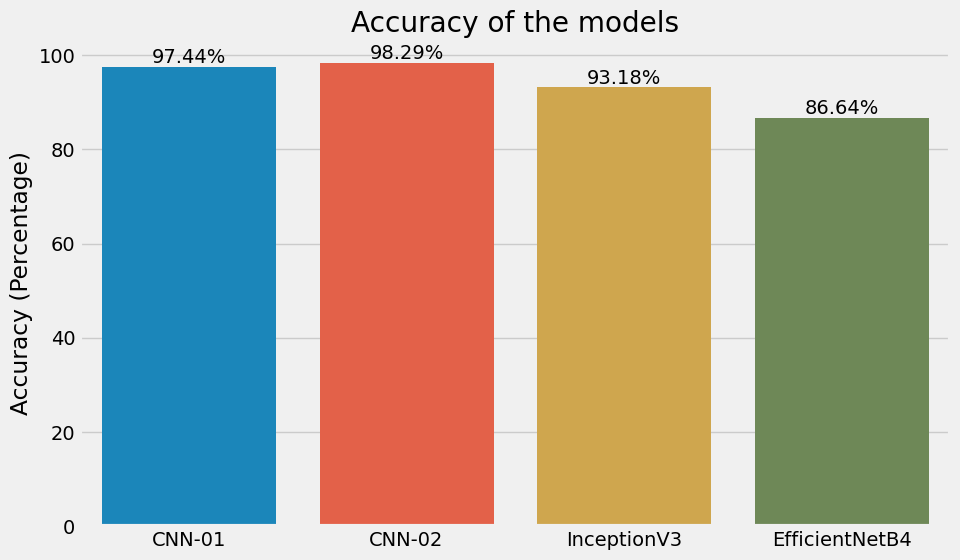

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

names = ['CNN-01', 'CNN-02', 'InceptionV3', 'EfficientNetB4']
accuracy = [97.44, 98.29, 93.18, 86.64]

# Set the width and height of the figure
plt.figure(figsize=(10, 6))

# Add title
plt.title("Accuracy of the models")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=names, y=accuracy)

# Add label for vertical axis
plt.ylabel("Accuracy (Percentage)")

# Add data labels above the bars
for i, v in enumerate(accuracy):
    plt.text(i, v, str(v) + '%', color='black', ha='center', va='bottom')

# Show the plot
plt.show()
